$$ \frac{\partial C}{\partial Z}= CU , \frac{\partial E}{\partial Z} =0, \frac{\partial S}{\partial Z} =0$$
$$FC=SCE $$
$$\frac{\partial F}{\partial Z}C + FCU =SCUE $$

$$C^\dagger \frac{\partial F}{\partial Z_\alpha} C =C^\dagger SCUE - C^\dagger FCU $$
$$C^\dagger \frac{\partial F}{\partial Z_\alpha} C = UE -EU $$

AS a first approx. dF= dV
$$ C^\dagger \frac{\partial F}{\partial Z_\alpha} C =C^\dagger \frac{\partial V_{ne}}{\partial Z_\alpha} C = UE - EU $$
Can decompose:
$$ \left( UE - EU \right)_{ij} = \sum_k U_{ik}\delta_{kj} \epsilon_j - \epsilon_i \delta_{ik} U_{kj} = U_{ij}(\epsilon_j - \epsilon_i)$$
then:
$$ U_{ij} \approx \left ( C^\dagger \frac{\partial V_{ne}}{\partial Z_\alpha} C \right)_{ij} / (\epsilon_j - \epsilon_i) $$
where $(\epsilon_j - \epsilon_i) \ne 0 $

For the derivatives of the density matrix, using the skew symmetry of the response matrix $U=-U^\dagger$:
$$ P=COC^\dagger$$
$$\frac{\partial P}{\partial Z_\alpha}=CUOC^\dagger + COU^\dagger C^\dagger = C(UO-OU)C^\dagger $$

Then use this expression to solve iteratively:
$$ C^\dagger \frac{\partial F}{\partial Z_\alpha} C =C^\dagger  \frac{\partial \left( V_{ne}+ V_{ee}(P) \right ) }{\partial Z_\alpha} C = UE - EU $$
Where:
$$ \frac{\partial V_{ee}}{\partial Z_\alpha} = \sum_{kl}\left( g_{ikjl} - g_{ijkl}/2 \right ) \left( \frac{\partial P}{\partial Z_\alpha} \right ) _{kl} $$
And if $E$ is diagonal:
$$ \left( UE -EU   \right)_{ij}= \sum_k\left( U_{ik}E_{kj} -E_{ik}U_{kj} \right)= U_{ij}\left( \epsilon_j -\epsilon_i  \right) $$

$$ C^\dagger  \left(dV+ \sum_{kl}(G_{ikjl} dP_{kl}) \right)C = U_{ij}\left( \epsilon_j -\epsilon_i  \right) $$
$$ dP= C(UO-OU)C^\dagger $$

In [30]:
from pyscf import gto, scf
import scipy
import inspect
import pyscf.qmmm
import pyscf.dft
import numpy as np
angstrom = 1 / 0.52917721067
from matplotlib import pyplot as plt
from functools import reduce
from numpy.linalg import inv 
# ancora il modo migliore per mettere cariche frazionali sulle molecole, se vai a toccare mol.charges si incazza 
#  quando deve calcolare l' initial guess 
def fc(calc,deltaZ):
    mf = pyscf.qmmm.mm_charge(calc, calc.mol.atom_coords(), deltaZ)  # now is add_mm_charge
    class NoSelfQMMM(mf.__class__):
        def energy_nuc(self):
            q = self.mol.atom_charges().astype(np.float).copy()
            q1 =q+ np.asarray(deltaZ) 
            return self.mol.energy_nuc(q1)
    return(NoSelfQMMM(mf,mf.mm_mol))

def DeltaV(mol,dL):
    mol.set_rinv_orig_(mol.atom_coords()[0])
    dV=mol.intor('int1e_rinv')*dL[0]
    mol.set_rinv_orig_(mol.atom_coords()[1])
    dV+=mol.intor('int1e_rinv')*dL[1]
    return -dV

In [31]:
co=gto.Mole(atom="C 0 0 0 ;O 0 0 2.1", basis= "cc-pvtz",unit="Bohr",maxit=100)
hfco=scf.RHF(co)
hfco.scf()

converged SCF energy = -112.781687962358


Initialize <pyscf.gto.mole.Mole object at 0x7fc377254cc0> in <pyscf.scf.hf.RHF object at 0x7fc377254828>


-112.78168796235815

In [32]:
dL=.0001
hf1=fc(hfco,[dL,-dL])
hf1.scf()
hf2=fc(hfco,[-dL,dL])
hf2.scf()
dV=DeltaV(co,[dL,-dL])
print(np.allclose(dV,hf1.get_hcore()-hfco.get_hcore()))

converged SCF energy = -112.780928838413
converged SCF energy = -112.782447152102
True


In [33]:
C=hfco.mo_coeff
S=hfco.get_ovlp()
e=hfco.mo_energy
E=np.diag(e)
O=np.diag(hfco.mo_occ)
C1=hf1.mo_coeff
P=hfco.make_rdm1()
P1=hf1.make_rdm1()
P2=hf2.make_rdm1()
dP=(P1-P2)/2
dC=(abs(C1)*C/abs(C)-C)

In [34]:
h2=hfco.get_veff()
J,K=hfco.get_jk()
g_ijkl=hfco.mol.intor('int2e_sph')
print( "J-K/2 = H2 :",np.allclose(h2,J-K/2))

J-K/2 = H2 : True


In [35]:
print(np.allclose(np.einsum('ijkl,kl->ij',g_ijkl,P ),J))
print(np.allclose(np.einsum('ijkl,jl->ik',g_ijkl,P ),K))

True
True


In [37]:
g_h2=g_ijkl-np.swapaxes(g_ijkl,1,2)/2
U_app=C.T.dot(dV.dot(C))  # approximate value of U
for i in range(co.nao):
    for j in range(co.nao):
        if e[i]!=e[j]:
            U_app[i][j]/=(e[j]-e[i])
dP_app=C.dot(U_app.dot(O)-O.dot(U_app)).dot(C.T)
#plt.matshow(dP_app)
#plt.matshow(dP)
print(np.linalg.norm(dP))
print(np.linalg.norm(dP_app))
print(np.linalg.norm(dP_app-dP))

0.00043012683954990065
0.0004529633788788574
8.659044715774155e-05


In [38]:
TM= (U_app.dot(O)-O.dot(U_app))
np.allclose(TM,TM.T)

True

In [39]:
g_h2=g_ijkl-np.swapaxes(g_ijkl,1,2)/2
for i in range(10):
    U_app=C.T.dot((dV+np.einsum('ijkl,kl->ij',g_h2,dP_app)).dot(C)) # approximate value of U
    for i in range(co.nao):
        for j in range(co.nao):
            if e[i]!=e[j]:
                U_app[i][j]/=(e[j]-e[i])
    dP_app=C.dot(U_app.dot(O)-O.dot(U_app)).dot(C.T)
    #plt.matshow(dP_app)
    #plt.matshow(dP)
    print(np.linalg.norm(dP))
    print(np.linalg.norm(dP_app))
    print(np.linalg.norm(dP_app-dP))

0.00043012683954990065
0.0004175379613419781
7.781482627594087e-05
0.00043012683954990065
0.0004498679968210256
6.403909537850035e-05
0.00043012683954990065
0.00042000838895050633
5.5603984570911964e-05
0.00043012683954990065
0.0004439638376225452
4.724259398921266e-05
0.00043012683954990065
0.00042209886797917246
4.0515193443143754e-05
0.00043012683954990065
0.0004398258778013983
3.461776798246304e-05
0.00043012683954990065
0.0004238971508317851
2.9623035101523726e-05
0.00043012683954990065
0.0004369786063358097
2.5333975250271378e-05
0.00043012683954990065
0.00042537651169577466
2.1671089492521405e-05
0.00043012683954990065
0.00043500601978396357
1.8535982420168116e-05


In [40]:
dEnn=(49-48)/2.1
print("true target energy: ",fc(hfco,[1,-1]).scf())
print("CO energy = ",hfco.e_tot)
print("APDFT1 energy =", hfco.e_tot+dEnn+np.trace(P.dot(dV/dL)))
print("APDFT2 energy =", hfco.e_tot+dEnn+np.trace((P+0.5*dP/dL).dot(dV/dL)))
print("APDFT2 energy approx.=", hfco.e_tot+dEnn+np.trace((P+0.5*dP_app/dL).dot(dV/dL)))

converged SCF energy = -108.474476524995
true target energy:  -108.4744765249953
CO energy =  -112.78168796235815
APDFT1 energy = -105.66630780294982
APDFT2 energy = -108.48008206006587
APDFT2 energy approx.= -108.71895486294765


In [41]:
np.trace((P+dP_app).dot(S))

14.000000000000007

#### Comments
It works pretty well for minimal basis set, good results were obtained with few iterations. <br>
For larger basis set an acceptable convergence can be obtained only after 20-30 iterations <br>
dL affects the results for dP calculated numerically, but not analytically, thus is to be chosen a small dL ($10^{-3} / 10^{-4} $) in order to compare dP_approximated with a proper numerical dP.


In [47]:
fc(hfco,[2,-2]).scf()

converged SCF energy = -110.646619026948


-110.64661902694783

converged SCF energy = -140.922830206771
converged SCF energy = -131.509976945528
converged SCF energy = -123.651304401655
converged SCF energy = -117.399142874555
converged SCF energy = -112.781687962358
converged SCF energy = -109.808160125786
converged SCF energy = -108.474476524995
converged SCF energy = -108.764544050183
converged SCF energy = -110.646619026948
converged SCF energy = -114.068327856904
converged SCF energy = -118.955890001861


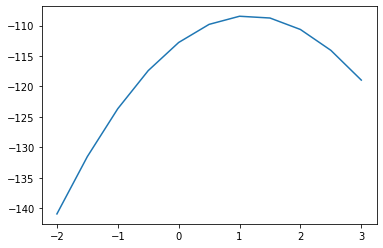

In [46]:
xp=np.linspace(-2,3,11)
yp=[]
for dl in xp:
    yp.append(fc(hfco,[dl,-dl]).kernel())
plt.plot(xp,yp)